In [8]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############

import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',

}


try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)




i'm connected


In [16]:
def desc_stats(table='hmdalar2014', field= 'amount', where_max=None, where_min=None):
    base_sql = """SELECT year, COUNT({field}) AS count_loans, SUM({field}::INT) AS sum_amt, AVG({field}::INT) AS avg_{field}, 
    STDDEV({field}::INT) AS std_{field}, MIN({field}::INT) AS min_{field}, MAX({field}::INT) AS max_{field}""".format(field=field)
    table_sql = "\nFROM {table}\n".format(table=table) 
    where_sql = "WHERE property_type = '1' AND loan_purpose = '1' AND agency != '7' AND {field} NOT ILIKE '%NA%' ".format(field=field)
    if where_max:
        where_sql = where_sql + "AND {field}::INT < ".format(field=field) + str(where_max)
    if where_min:
        where_sql = where_sql + "AND {field}::INT > ".format(field=field) + str(where_min)
    group_sql = """ GROUP BY year"""
    
    return_sql = base_sql + table_sql + where_sql + group_sql
    print(return_sql)
    return return_sql 

In [ ]:

#get descriptive statistics for the field named
#FIXME add an optional set of limits to look at sub distributions min/max= 10/600? set by cumulative probability
year = 2014
first = True
field = 'income'
where_max = 650
where_min = 5
while year > 2003:
    table = 'hmdalar' + str(year)
    print(table)
    #cur.execute(desc_stats(table=table, field=field))        
    cur.execute(desc_stats(table=table, field=field, where_max=where_max, where_min=where_min))        
    data_df = pd.DataFrame(cur.fetchall())

    col_names = [desc[0] for desc in cur.description]
    if len(data_df.columns) == len(col_names):
        print('setting column names')
        data_df.columns = col_names

    if first == True and len(data_df.columns) > 0:
        dist_df = data_df.copy()
        first = False

    elif first == False and len(data_df.columns) > 0:
        print('merging dataframes')
        dist_df=dist_df.merge(data_df, how='outer')

    else:
        print('no data returned from query')
    dist_df['5_pct'] = dist_df['avg_{field}'.format(field=field)] - 2*dist_df['std_{field}'.format(field=field)]
    dist_df['95_pct'] = dist_df['avg_{field}'.format(field=field)] + 2*dist_df['std_{field}'.format(field=field)]
    print(dist_df.head())
    path = 'dist_csvs/'
    if not os.path.exists(path):
        os.makedirs(path)
    year -= 1
dist_df.to_csv(path + '{field}_desc_stats.csv'.format(field=field),index=False)

hmdalar2014
SELECT year, COUNT(income) AS count_loans, SUM(income::INT) AS sum_amt, AVG(income::INT) AS avg_income, 
    STDDEV(income::INT) AS std_income, MIN(income::INT) AS min_income, MAX(income::INT) AS max_income
FROM hmdalar2014
WHERE property_type = '1' AND loan_purpose = '1' AND agency != '7' AND income NOT ILIKE '%NA%' AND income::INT < 650AND income::INT > 5 GROUP BY year
setting column names
   year  count_loans    sum_amt            avg_income           std_income  \
0  2014      2859862  296642880  103.7262916882003397  85.8365794898239640   

   min_income  max_income                 5_pct                95_pct  
0           6         649  -67.9468672914475883  275.3994506678482677  
hmdalar2013
SELECT year, COUNT(income) AS count_loans, SUM(income::INT) AS sum_amt, AVG(income::INT) AS avg_income, 
    STDDEV(income::INT) AS std_income, MIN(income::INT) AS min_income, MAX(income::INT) AS max_income
FROM hmdalar2013
WHERE property_type = '1' AND loan_purpose = '1' AND age

In [4]:
print('done')

done


In [45]:
#get distributions of values for fields
def field_dist(field='income', table='hmdalar2014', prop_type='1', loan_purp='1', loan_type='1'):
    dist_sql = """SELECT DISTINCT year, {field}, COUNT({field}) FROM {table} """.format(table=table, field=field) 
    #removing the bulk of quesitonable data in exploration by removing HUD
    where_sql = """WHERE agency != '7' AND property_type IN ('{prop_type}') AND loan_purpose IN ('{loan_purp}') 
    AND loan_type IN ('{loan_type}') """.format(prop_type=prop_type, loan_purp=loan_purp, loan_type=loan_type)
    order_sql = """ORDER by {field} ASC """.format(field=field)
    group_sql = """GROUP BY {field}, year """.format(field=field)
    return dist_sql + where_sql + group_sql + order_sql 

In [46]:
year = 2014
first = True
field = 'amount'
while year > 2003:
    table = 'hmdalar' + str(year)
    print(table)
    cur.execute(field_dist(table=table, field=field))        
    data_df = pd.DataFrame(cur.fetchall())

    col_names = [desc[0] for desc in cur.description]
    if len(data_df.columns) == len(col_names):
        print('setting column names')
        data_df.columns = col_names

    if first == True and len(data_df.columns) > 0:
        dist_df = data_df.copy()
        first = False

    elif first == False and len(data_df.columns) > 0:
        print('merging dataframes')
        dist_df=dist_df.merge(data_df, how='outer')

    else:
        print('no data returned from query')

    print(dist_df.head())
    path = 'dist_csvs/'
    if not os.path.exists(path):
        os.makedirs(path)
    dist_df.to_csv(path + '{field}_dist.csv'.format(field=field),index=False)
    year -= 1

hmdalar2014
setting column names
   year amount  count
0  2014  00001   2190
1  2014  00002    919
2  2014  00003   1305
3  2014  00004   1490
4  2014  00005   2307
hmdalar2013
setting column names
merging dataframes
   year amount   count
0  2014  00001  2190.0
1  2014  00002   919.0
2  2014  00003  1305.0
3  2014  00004  1490.0
4  2014  00005  2307.0
hmdalar2012
setting column names
merging dataframes
   year amount   count
0  2014  00001  2190.0
1  2014  00002   919.0
2  2014  00003  1305.0
3  2014  00004  1490.0
4  2014  00005  2307.0
hmdalar2011
setting column names
merging dataframes
   year amount   count
0  2014  00001  2190.0
1  2014  00002   919.0
2  2014  00003  1305.0
3  2014  00004  1490.0
4  2014  00005  2307.0
hmdalar2010
setting column names
merging dataframes
   year amount   count
0  2014  00001  2190.0
1  2014  00002   919.0
2  2014  00003  1305.0
3  2014  00004  1490.0
4  2014  00005  2307.0
hmdalar2009
setting column names
merging dataframes
   year amount   count


In [234]:
#convert distribution to percent
dist_2014 = dist_df[dist_df.year == '2014'].copy()
dist_2014.amount = dist_2014.amount.astype(int)

dist_2014['pct_count']=round(dist_2014['count']/dist_2014['count'].sum(),4)
dist_2014['pct_amt']=dist_2014['amount']/dist_2014['amount'].sum()
dist_2014['cumul_count_pct'] = 0
dist_2014['cumul_amt_pct'] = 0
#add cumulative percent by count and amount
cumul_count = 0
cumul_amount = 0
for index, row in dist_2014.iterrows():
    cumul_count += row['pct_count']
    cumul_amount += row['pct_amt']
    dist_2014.loc[index, 'cumul_count_pct']= cumul_count
    dist_2014.loc[index, 'cumul_amt_pct'] = cumul_amount




In [236]:
round(dist_2014.cumul_amt_pct,10)*100

0         0.000011
1         0.000034
2         0.000067
3         0.000112
4         0.000168
5         0.000236
6         0.000314
7         0.000404
8         0.000505
9         0.000617
10        0.000740
11        0.000875
12        0.001021
13        0.001178
14        0.001346
15        0.001525
16        0.001716
17        0.001918
18        0.002131
19        0.002355
20        0.002591
21        0.002837
22        0.003095
23        0.003365
24        0.003645
25        0.003937
26        0.004239
27        0.004553
28        0.004879
29        0.005215
           ...    
3421     86.834469
3422     87.045877
3423     87.270182
3424     87.497998
3425     87.731276
3426     87.975208
3427     88.233159
3428     88.496718
3429     88.772614
3430     89.052996
3431     89.337303
3432     89.623292
3433     89.909428
3434     90.205511
3435     90.515052
3436     90.851511
3437     91.199184
3438     91.559194
3439     91.940514
3440     92.344264
3441     92.792875
3442     93.

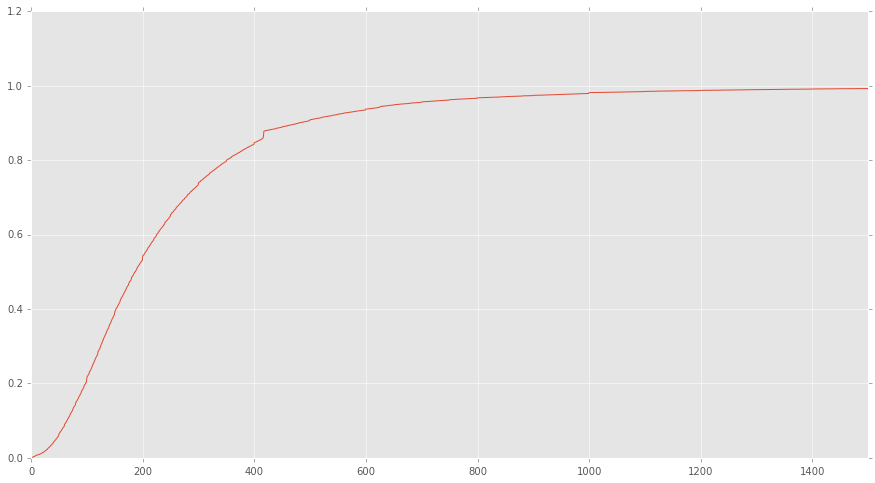

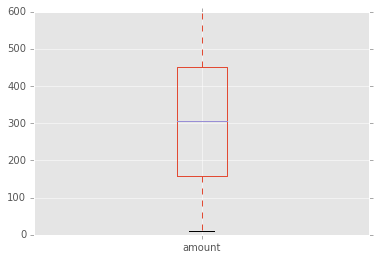

In [211]:
bin_size = Decimal(0)
binned_pct = {}
while bin_size <= Decimal(1):
    
    bin_start = bin_size #set start point for bin label
    bin_size += Decimal(.1) #increment bin
    bin_data = dist_2014['amount'][(dist_2014.cumul_pct >= bin_start) & (dist_2014.cumul_pct < bin_size)].sum().copy()
    #print(dist_2014['amount'][(dist_2014.cumul_pct >= bin_start) & (dist_2014.cumul_pct < bin_size)].sum().copy())
    binned_pct[str(bin_start) + ' to ' + str(bin_size)] = bin_data
#dist_2014[dist_2014.cumul_pct <= .10]
#binned_pct
#sums= dist_2014['amount'].sum()
#dist_2014['amount'][dist_2014.cumul_pct <= .1].sum()/sums
print(dist_2014.amount[dist_2014.cumul_pct < Decimal(.9)].sum())

dist_2014.amount[(dist_2014.cumul_pct >= Decimal(.9))].sum()# & (dist_2014.cumul_pct < Decimal(1))]

114960


8801452

In [216]:
binned_pct_df = pd.Series(binned_pct)#, columns = binned_pct.keys(), index=range(len(binned_pct.keys())))
binned_pct_df

0 to 0.1000000000000000055511151231                                    2080
0.1000000000000000055511151231 to 0.2000000000000000111022302462       2673
0.2000000000000000111022302462 to 0.3000000000000000166533453693       2997
0.3000000000000000166533453693 to 0.4000000000000000222044604924       3726
0.4000000000000000222044604924 to 0.5000000000000000277555756155       5915
0.5000000000000000277555756155 to 0.6000000000000000333066907386       7809
0.6000000000000000333066907386 to 0.7000000000000000388578058617      13026
0.7000000000000000388578058617 to 0.8000000000000000444089209848      23199
0.8000000000000000444089209848 to 0.9000000000000000499600361079      53535
0.9000000000000000499600361079 to 1.000000000000000055511151231     8701453
dtype: int64

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([   2080,    2673,    2997,    3726,    5915,    7809,   13026,
          23199,   53535, 8701453]),
 <a list of 9 Patch objects>)

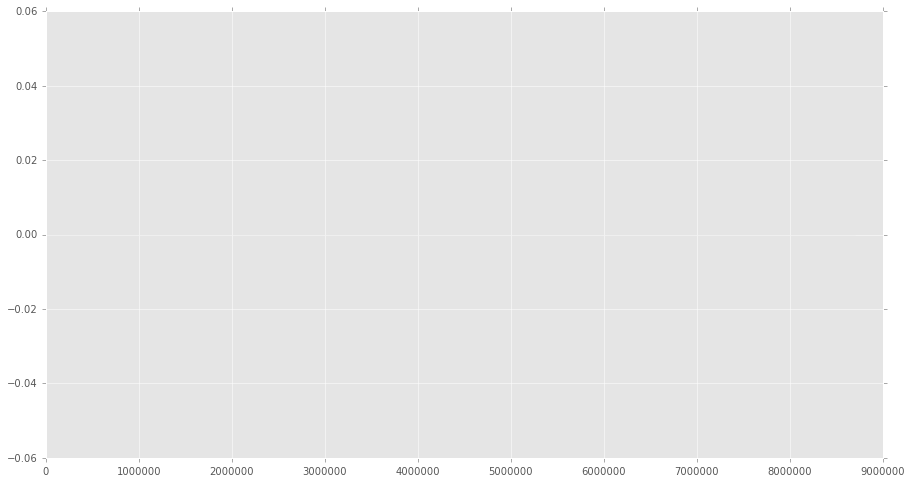

In [222]:

y = binned_pct_df
x = range(len(binned_pct_df))

plt.figure(figsize=(15,8))
plt.hist(x,y)
#plt.xlim(0, 1500)
#plt.plot(x,y)

